# LU IGI

## Making a model

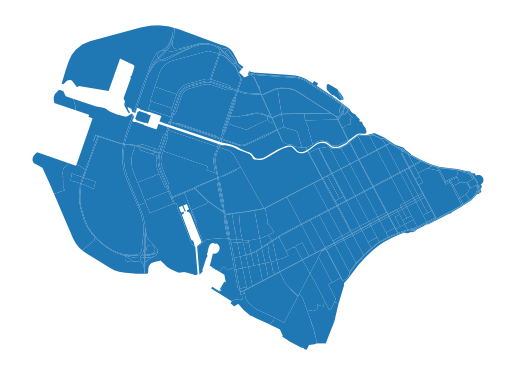

In [1]:
import osmnx as ox
import geopandas as gpd

blocks_gdf = gpd.read_parquet('data/spb_blocks.parquet')
blocks_gdf.head()
clip_gdf = ox.features_from_place('Санкт-Петербург', tags={'name':'Василеостровский район'}).to_crs(blocks_gdf.crs)
blocks_gdf = blocks_gdf[blocks_gdf.intersects(clip_gdf.union_all())]
blocks_gdf.plot().set_axis_off()

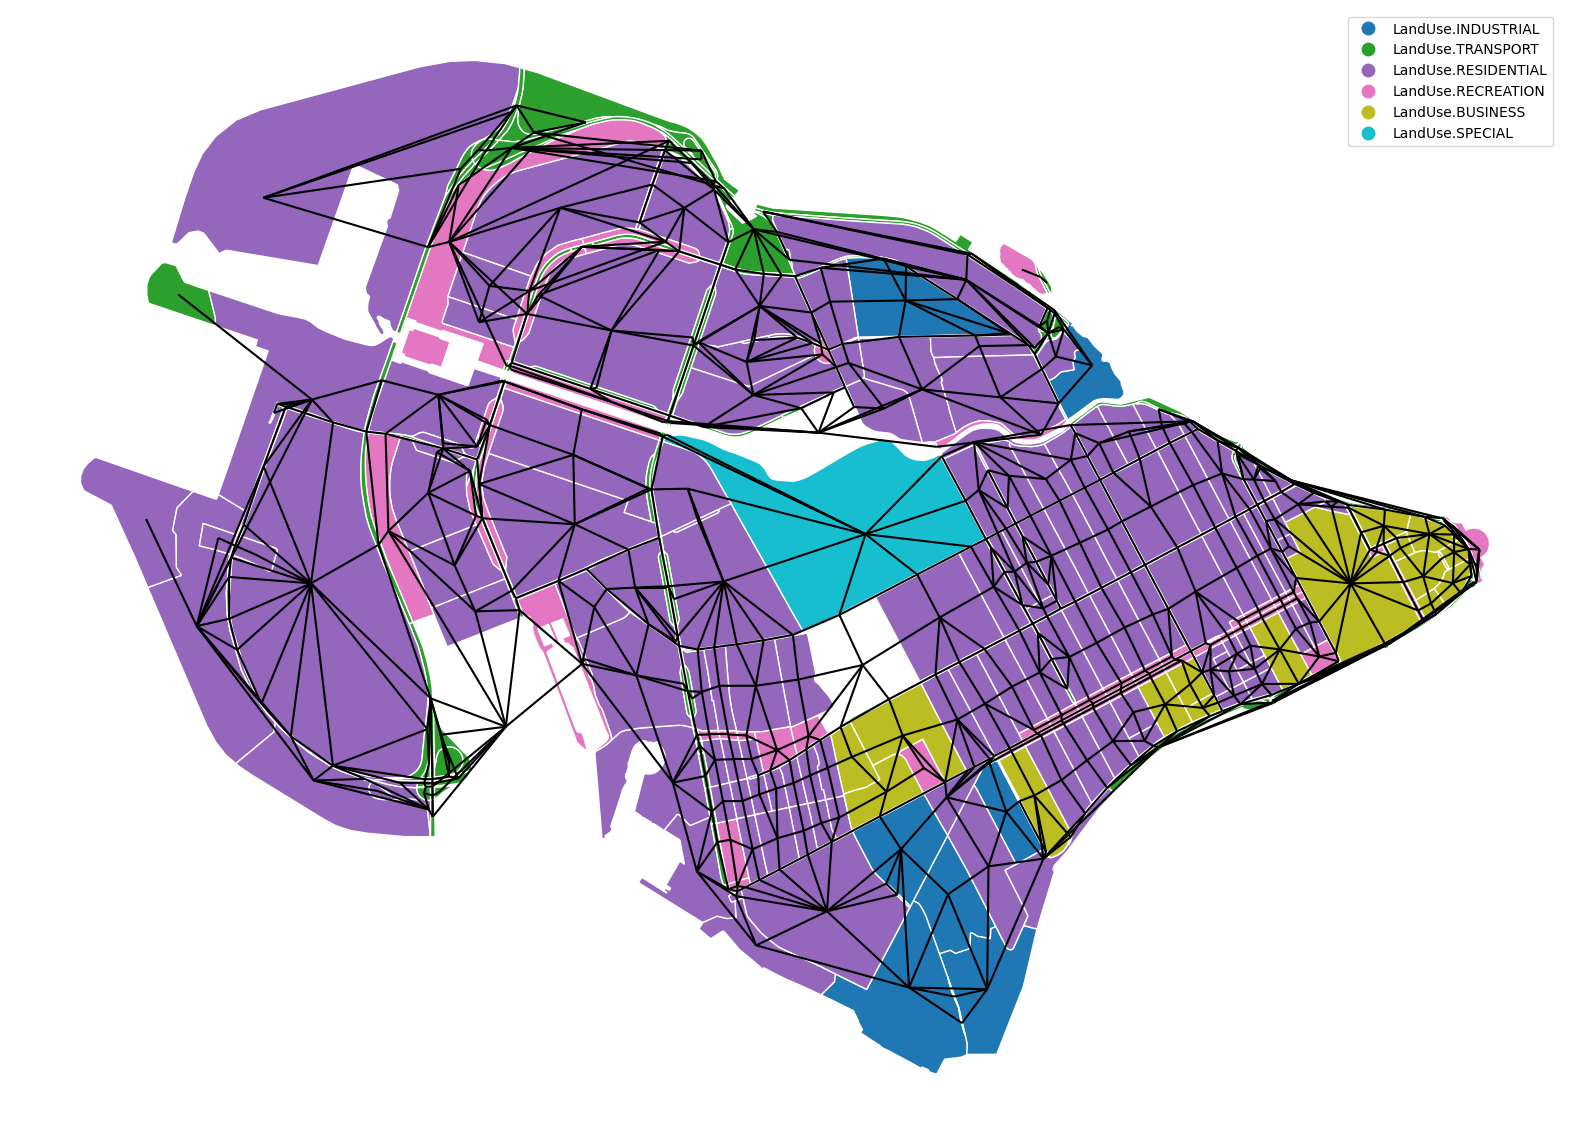

In [2]:
import random
from lu_igi.model import Model, LAND_USE_NAME
from lu_igi.land_use import LandUse

blocks_gdf[LAND_USE_NAME] = blocks_gdf['land_use'].apply(lambda lu : LandUse[lu] if lu is not None else None)
model = Model(blocks_gdf)
model.plot()

## Genetics

Selecting territory to be changed

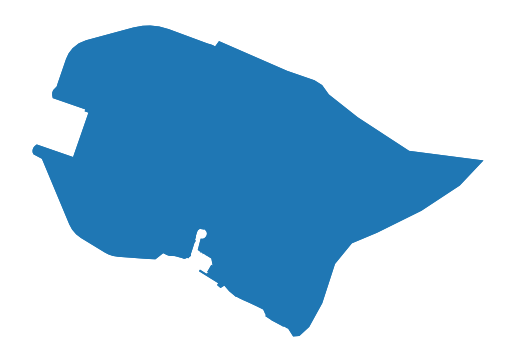

In [3]:
territory_gdf = ox.features_from_place('Санкт-Петербург', tags={'name':'Василеостровский район'}).to_crs(blocks_gdf.crs) # округ № 7
territory_gdf.plot().set_axis_off()

In [4]:
from lu_igi.pygad_optimizer import PygadOptimizer

pygad_optimizer = PygadOptimizer(model)

In [5]:
target_lu_shares = {
    LandUse.RESIDENTIAL : 0.5,
    LandUse.RECREATION : 0.3,
    LandUse.BUSINESS : 0.2
}

blocks_gdf, ga_instance = pygad_optimizer.run(territory_gdf, target_lu_shares, saturation=10, num_generations=100, sol_per_pop=10, mutation_probability=0.1)

  0%|          | 0/100 [00:00<?, ?it/s]/home/vasilstar/lu-igi/.venv/lib/python3.10/site-packages/pygad/pygad.py:1145: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")
100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


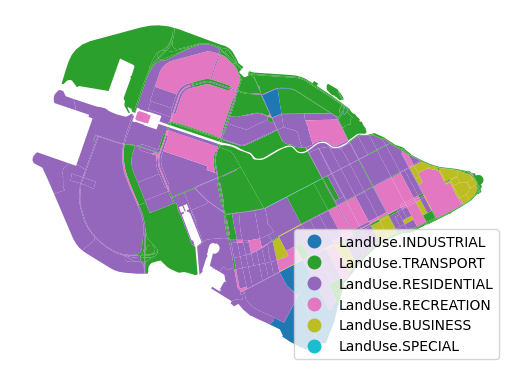

In [6]:
blocks_gdf.plot(column='assigned_land_use', legend=True, legend_kwds={'loc': 'lower right'}).set_axis_off()

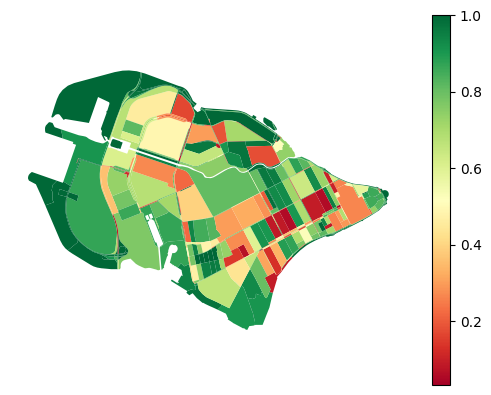

In [7]:
blocks_gdf['probability'] = blocks_gdf.apply(lambda s : s['probabilities'].get(s['assigned_land_use']), axis=1)
blocks_gdf.plot(column='probability', cmap='RdYlGn', legend=True).set_axis_off()

In [8]:
blocks_gdf.sort_values('probability')

,geometry,land_use,area,aspect_ratio,probabilities,assigned_land_use,probability
2419,"POLYGON ((346996.207 6647082.055, 346998.782 6...",LandUse.TRANSPORT,954.027323,3.142654,"{LandUse.RESIDENTIAL: 0.03229519806636248, Lan...",LandUse.RESIDENTIAL,0.032295
6700,"POLYGON ((348571.34 6647951.016, 348566.807 66...",LandUse.RECREATION,2901.753839,2.073825,"{LandUse.RESIDENTIAL: 0.18310057778439778, Lan...",LandUse.TRANSPORT,0.040369
6686,"POLYGON ((347613.445 6647488.65, 347612.064 66...",LandUse.RESIDENTIAL,74327.624234,2.798527,"{LandUse.RESIDENTIAL: 0.9046092708167413, Land...",LandUse.RECREATION,0.056646
6692,"POLYGON ((348273.501 6648340.945, 348290.858 6...",LandUse.RESIDENTIAL,75561.202751,2.779545,"{LandUse.RESIDENTIAL: 0.9039673912270941, Land...",LandUse.RECREATION,0.057042
12194,"POLYGON ((345398.884 6648976.001, 345417.852 6...",LandUse.TRANSPORT,12797.290645,31.020978,"{LandUse.RESIDENTIAL: 0.06183365732621035, Lan...",LandUse.RESIDENTIAL,0.061834
...,...,...,...,...,...,...,...
1240,"POLYGON ((345963.236 6647049.749, 345966.657 6...",LandUse.RESIDENTIAL,18739.519387,2.259244,"{LandUse.RESIDENTIAL: 1.0, LandUse.BUSINESS: 0...",LandUse.RESIDENTIAL,1.000000
1241,"POLYGON ((345993.175 6646903.112, 345991.53 66...",LandUse.RESIDENTIAL,21848.214104,2.458627,"{LandUse.RESIDENTIAL: 1.0, LandUse.BUSINESS: 0...",LandUse.RESIDENTIAL,1.000000
16180,"POLYGON ((346871.489 6645844.206, 346855.702 6...",LandUse.INDUSTRIAL,552.652748,30.797170,"{LandUse.RESIDENTIAL: 0.0, LandUse.BUSINESS: 0...",LandUse.INDUSTRIAL,1.000000
15895,"POLYGON ((344064.327 6649344.079, 344064.367 6...",LandUse.RECREATION,32633.431698,1.424999,{LandUse.RECREATION: 1.0},LandUse.RECREATION,1.000000


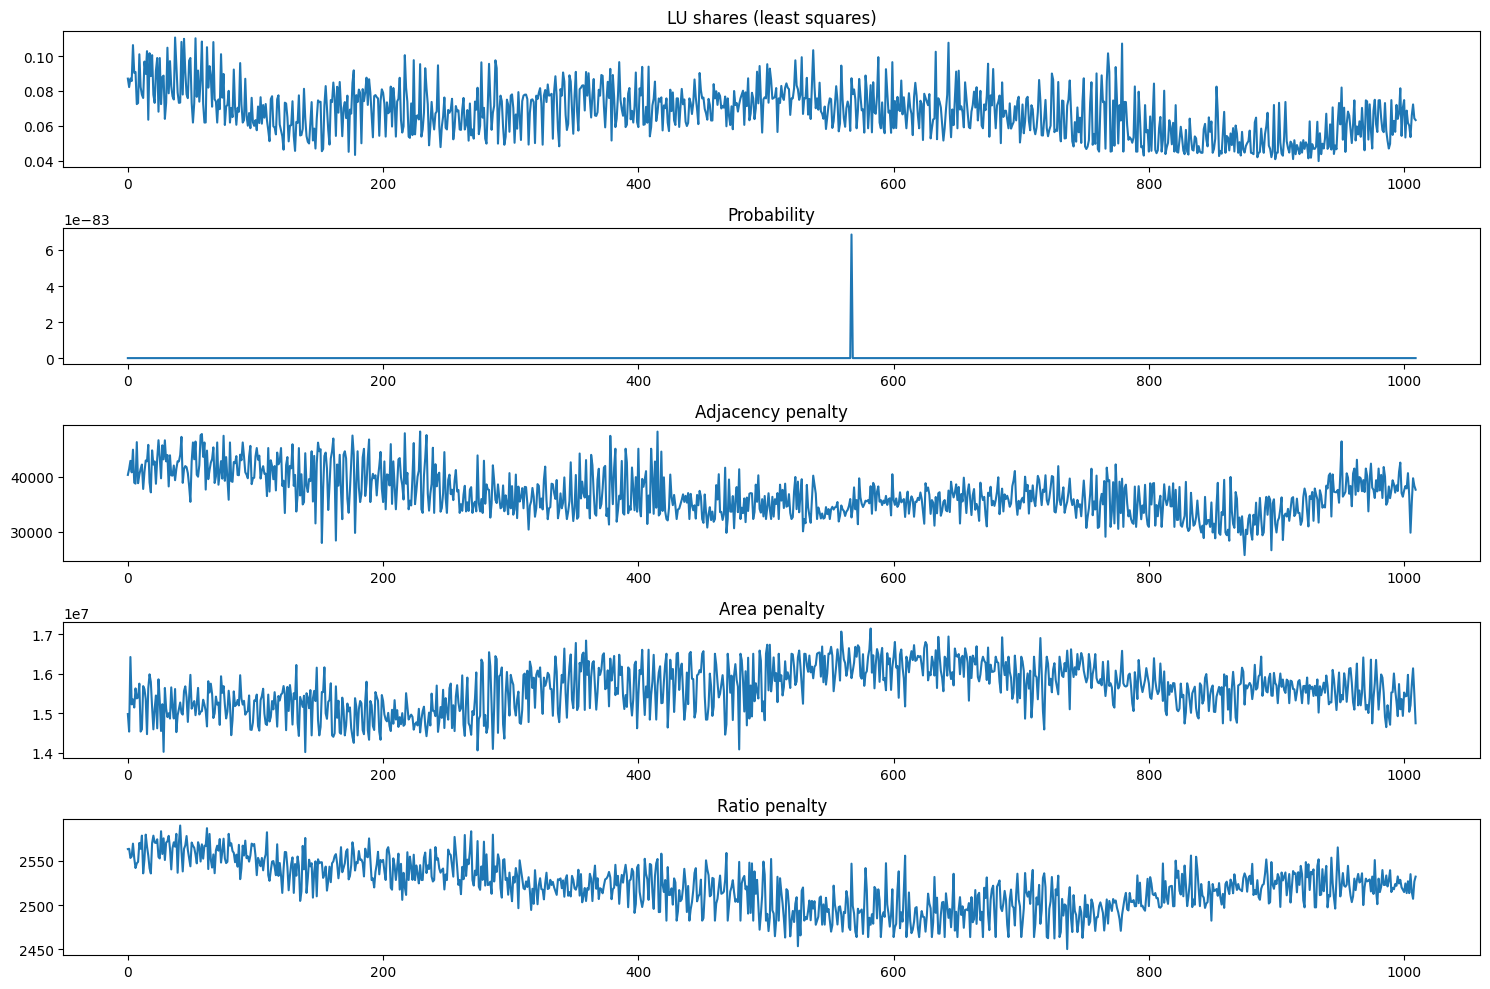

In [9]:
PygadOptimizer.plot_fitness(ga_instance)